<a href="https://colab.research.google.com/github/gobucbabu/safety-incident-analysis/blob/main/SIA_temp123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab file for my Safety incident analysis project.

### Imports and data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Load data - UPDATE PATH to your file location
file_path = '/content/drive/MyDrive/SIA project/ridkind.xlsx'

# Check sheets available
xl_file = pd.ExcelFile(file_path)
print("Available sheets:")
print(xl_file.sheet_names)

Available sheets:
['Contents', 'Guidance', 'Notes', 'Table 1', 'Table 2']


In [7]:
# Reload with proper headers
df_fatal = pd.read_excel(file_path, sheet_name='Table 1', skiprows=7)
df_nonfatal = pd.read_excel(file_path, sheet_name='Table 2', skiprows=7)

# Set proper column names (7 columns for fatal, 10 for non-fatal)
df_fatal.columns = ['Year', 'Industry_Section', 'Industry', 'Accident_Kind',
                    'Fatal_Workers', 'Fatal_Employees', 'Fatal_SelfEmployed']

df_nonfatal.columns = ['Year', 'Industry_Section', 'Industry', 'Accident_Kind',
                       'Total_NonFatal', 'Specified_Injuries', 'Over7Day_Injuries',
                       'Pct_Total', 'Pct_Specified', 'Pct_Over7Day']

# Remove first row (old headers)
df_fatal = df_fatal.iloc[1:].reset_index(drop=True)
df_nonfatal = df_nonfatal.iloc[1:].reset_index(drop=True)

# Add severity labels NOW
df_fatal['Severity'] = 'Fatal'
df_nonfatal['Severity'] = 'Non-Fatal'

# Basic info
print("✓ Fatal shape:", df_fatal.shape)
print("✓ Non-fatal shape:", df_nonfatal.shape)
print("\n" + "="*60)

# Quick data check
print("\nFATAL DATA:")
print(df_fatal.head())
print("\n" + "="*60)
print("\nNON-FATAL DATA:")
print(df_nonfatal.head())

✓ Fatal shape: (2803, 8)
✓ Non-fatal shape: (2804, 11)


FATAL DATA:
      Year Industry_Section        Industry  \
0  2014/15              A-U  All industries   
1  2014/15              A-U  All industries   
2  2014/15              A-U  All industries   
3  2014/15              A-U  All industries   
4  2014/15              A-U  All industries   

                                       Accident_Kind  Fatal_Workers  \
0  Struck by moving, including flying/falling, ob...             19   
1                           Struck by moving vehicle             22   
2       Strike against something fixed or stationary              0   
3        Injured while handling, lifting or carrying              0   
4                Slips, trips or falls on same level              2   

   Fatal_Employees  Fatal_SelfEmployed Severity  
0               12                   7    Fatal  
1               16                   6    Fatal  
2                0                   0    Fatal  
3                0   

### Initial exploration

In [8]:
# Check for missing values
print("MISSING VALUES:")
print("Fatal:", df_fatal.isnull().sum().sum())
print("Non-fatal:", df_nonfatal.isnull().sum().sum())
print("\n" + "="*60)

# Unique values
print("\nUNIQUE YEARS:")
print("Fatal:", sorted(df_fatal['Year'].unique()))
print("Non-fatal:", sorted(df_nonfatal['Year'].unique()))
print("\n" + "="*60)

print("\nUNIQUE ACCIDENT TYPES:")
print(df_fatal['Accident_Kind'].unique()[:15])  # First 15
print("\n" + "="*60)

print("\nUNIQUE INDUSTRIES:")
print(df_fatal['Industry'].unique()[:15])  # First 15
print("\n" + "="*60)

# Check for zeros/nulls in count columns
print("\nFATAL WORKERS - Value counts:")
print(df_fatal['Fatal_Workers'].value_counts().head(10))
print("\n" + "="*60)

print("\nTOTAL NON-FATAL - Sample stats:")
print(df_nonfatal['Total_NonFatal'].describe())

MISSING VALUES:
Fatal: 0
Non-fatal: 0


UNIQUE YEARS:
Fatal: ['2014/15', '2015/16', '2016/17', '2017/18', '2018/19', '2019/20 [Note 10]', '2020/21 [Note 10]', '2021/22 [Note 10]', '2022/23', '2023/24r', '2024/25p']
Non-fatal: ['2014/15', '2015/16', '2016/17', '2017/18', '2018/19', '2019/20 [Note 10]', '2020/21 [Note 10]', '2021/22 [Note 10]', '2022/23', '2023/24r', '2024/25p']


UNIQUE ACCIDENT TYPES:
['Struck by moving, including flying/falling, object'
 'Struck by moving vehicle' 'Strike against something fixed or stationary'
 'Injured while handling, lifting or carrying'
 'Slips, trips or falls on same level' 'Falls from a height'
 'Trapped by something collapsing/overturning' 'Drowning or asphyxiation'
 'Exposure to, or contact with, a harmful substance' 'Exposure to fire'
 'Exposure to an explosion'
 'Contact with electricity or electrical discharge' 'Injured by an animal'
 'Acts of violence' 'Other kind of accident']


UNIQUE INDUSTRIES:
['All industries' 'Agriculture, forestry a

### Cleaning and preperation

In [9]:
# Clean year column (remove notes)
df_fatal['Year_Clean'] = df_fatal['Year'].str.extract(r'(\d{4}/\d{2})')[0]
df_nonfatal['Year_Clean'] = df_nonfatal['Year'].str.extract(r'(\d{4}/\d{2})')[0]

# Convert numeric columns (some may have [k] or other markers)
numeric_cols_fatal = ['Fatal_Workers', 'Fatal_Employees', 'Fatal_SelfEmployed']
numeric_cols_nonfatal = ['Total_NonFatal', 'Specified_Injuries', 'Over7Day_Injuries']

for col in numeric_cols_fatal:
    df_fatal[col] = pd.to_numeric(df_fatal[col], errors='coerce').fillna(0).astype(int)

for col in numeric_cols_nonfatal:
    df_nonfatal[col] = pd.to_numeric(df_nonfatal[col], errors='coerce').fillna(0).astype(int)

# Check cleaning
print("✓ Years cleaned")
print("✓ Numeric columns converted")
print("\n" + "="*60)

# Summary stats
print("\nFATAL INCIDENTS BY YEAR:")
print(df_fatal.groupby('Year_Clean')['Fatal_Workers'].sum().sort_index())
print("\n" + "="*60)

print("\nNON-FATAL INCIDENTS BY YEAR:")
print(df_nonfatal.groupby('Year_Clean')['Total_NonFatal'].sum().sort_index())
print("\n" + "="*60)

print("\nTOP 10 ACCIDENT TYPES (Fatal):")
print(df_fatal.groupby('Accident_Kind')['Fatal_Workers'].sum().sort_values(ascending=False).head(10))

✓ Years cleaned
✓ Numeric columns converted


FATAL INCIDENTS BY YEAR:
Year_Clean
2014/15    413
2015/16    588
2016/17    540
2017/18    564
2018/19    596
2019/20    452
2020/21    580
2021/22    492
2022/23    544
2023/24    552
2024/25    496
Name: Fatal_Workers, dtype: int64


NON-FATAL INCIDENTS BY YEAR:
Year_Clean
2014/15    227757
2015/16    288116
2016/17    279648
2017/18    281808
2018/19    277224
2019/20    262172
2020/21    204916
2021/22    249924
2022/23    245624
2023/24    249640
2024/25    236876
Name: Total_NonFatal, dtype: int64


TOP 10 ACCIDENT TYPES (Fatal):
Accident_Kind
All accident kinds                                    2844
Falls from a height                                    806
Struck by moving vehicle                               530
Struck by moving, including flying/falling, object     426
Trapped by something collapsing/overturning            312
Contact with moving machinery                          239
Contact with electricity or electrical disc

In [10]:
# Filter out aggregate rows
df_fatal_clean = df_fatal[
    (df_fatal['Industry'] != 'All industries') &
    (df_fatal['Accident_Kind'] != 'All accident kinds')
].copy()

df_nonfatal_clean = df_nonfatal[
    (df_nonfatal['Industry'] != 'All industries') &
    (df_nonfatal['Accident_Kind'] != 'All accident kinds')
].copy()

print(f"Fatal: {df_fatal.shape[0]} → {df_fatal_clean.shape[0]} rows")
print(f"Non-fatal: {df_nonfatal.shape[0]} → {df_nonfatal_clean.shape[0]} rows")

# Check for duplicates
print(f"\nDuplicates - Fatal: {df_fatal_clean.duplicated().sum()}")
print(f"Duplicates - Non-fatal: {df_nonfatal_clean.duplicated().sum()}")

# Create simplified industry categories (shorten long names)
df_fatal_clean['Industry_Short'] = df_fatal_clean['Industry'].str[:50]
df_nonfatal_clean['Industry_Short'] = df_nonfatal_clean['Industry'].str[:50]

print("\n✓ Aggregates removed")
print("✓ Industry names shortened")
print("✓ Data cleaned and ready for analysis")

Fatal: 2803 → 2464 rows
Non-fatal: 2804 → 2464 rows

Duplicates - Fatal: 0
Duplicates - Non-fatal: 0

✓ Aggregates removed
✓ Industry names shortened
✓ Data cleaned and ready for analysis


### EDA

PHASE 2: EXPLORATORY DATA ANALYSIS


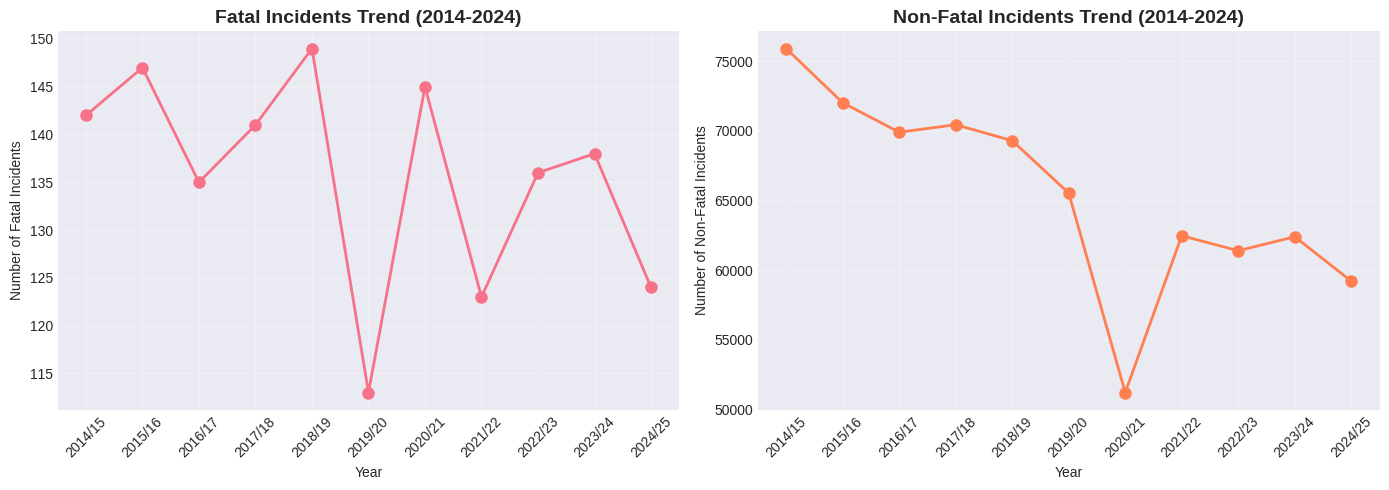


✓ Visualization 1: Trends over time


In [11]:
# EXPLORATORY DATA ANALYSIS
print("="*60)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. TREND OVER TIME
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fatal trends
fatal_by_year = df_fatal_clean.groupby('Year_Clean')['Fatal_Workers'].sum().sort_index()
axes[0].plot(fatal_by_year.index, fatal_by_year.values, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Fatal Incidents Trend (2014-2024)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Fatal Incidents')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Non-fatal trends
nonfatal_by_year = df_nonfatal_clean.groupby('Year_Clean')['Total_NonFatal'].sum().sort_index()
axes[1].plot(nonfatal_by_year.index, nonfatal_by_year.values, marker='o', linewidth=2, markersize=8, color='coral')
axes[1].set_title('Non-Fatal Incidents Trend (2014-2024)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Non-Fatal Incidents')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Visualization 1: Trends over time")

In [12]:
# SAVE CHECKPOINT TO GITHUB

# 1. Save cleaned datasets
df_fatal_clean.to_csv('fatal_incidents_cleaned.csv', index=False)
df_nonfatal_clean.to_csv('nonfatal_incidents_cleaned.csv', index=False)

print("✓ Datasets saved:")
print("  - fatal_incidents_cleaned.csv")
print("  - nonfatal_incidents_cleaned.csv")

# 2. Create checkpoint summary
checkpoint_summary = """
# Safety Incident Analysis - Checkpoint

## Progress Summary
- ✓ Data acquired from HSE RIDDOR
- ✓ Data loaded and cleaned
- ✓ Aggregate rows filtered out
- ✓ Initial trend visualization created

## Datasets
- **fatal_incidents_cleaned.csv**: 2,464 rows, 9 columns
- **nonfatal_incidents_cleaned.csv**: 2,464 rows, 12 columns

## Key Findings So Far
- Fatal incidents: Range 113-149 per year
- Non-fatal incidents: Dropped significantly in 2020/21 (COVID impact)
- Data spans 2014/15 to 2024/25

## Next Steps
- Top incident types visualization
- Geographic/industry distribution
- Severity breakdown
- Statistical analysis
- ML modeling
"""

with open('CHECKPOINT.md', 'w') as f:
    f.write(checkpoint_summary)

print("\n✓ Checkpoint summary saved: CHECKPOINT.md")

print("\n" + "="*60)
print("FILES READY TO COMMIT TO GITHUB:")
print("  1. fatal_incidents_cleaned.csv")
print("  2. nonfatal_incidents_cleaned.csv")
print("  3. CHECKPOINT.md")
print("\nDownload these from Colab Files panel → Upload to your GitHub repo")

✓ Datasets saved:
  - fatal_incidents_cleaned.csv
  - nonfatal_incidents_cleaned.csv

✓ Checkpoint summary saved: CHECKPOINT.md

FILES READY TO COMMIT TO GITHUB:
  1. fatal_incidents_cleaned.csv
  2. nonfatal_incidents_cleaned.csv
  3. CHECKPOINT.md

Download these from Colab Files panel → Upload to your GitHub repo


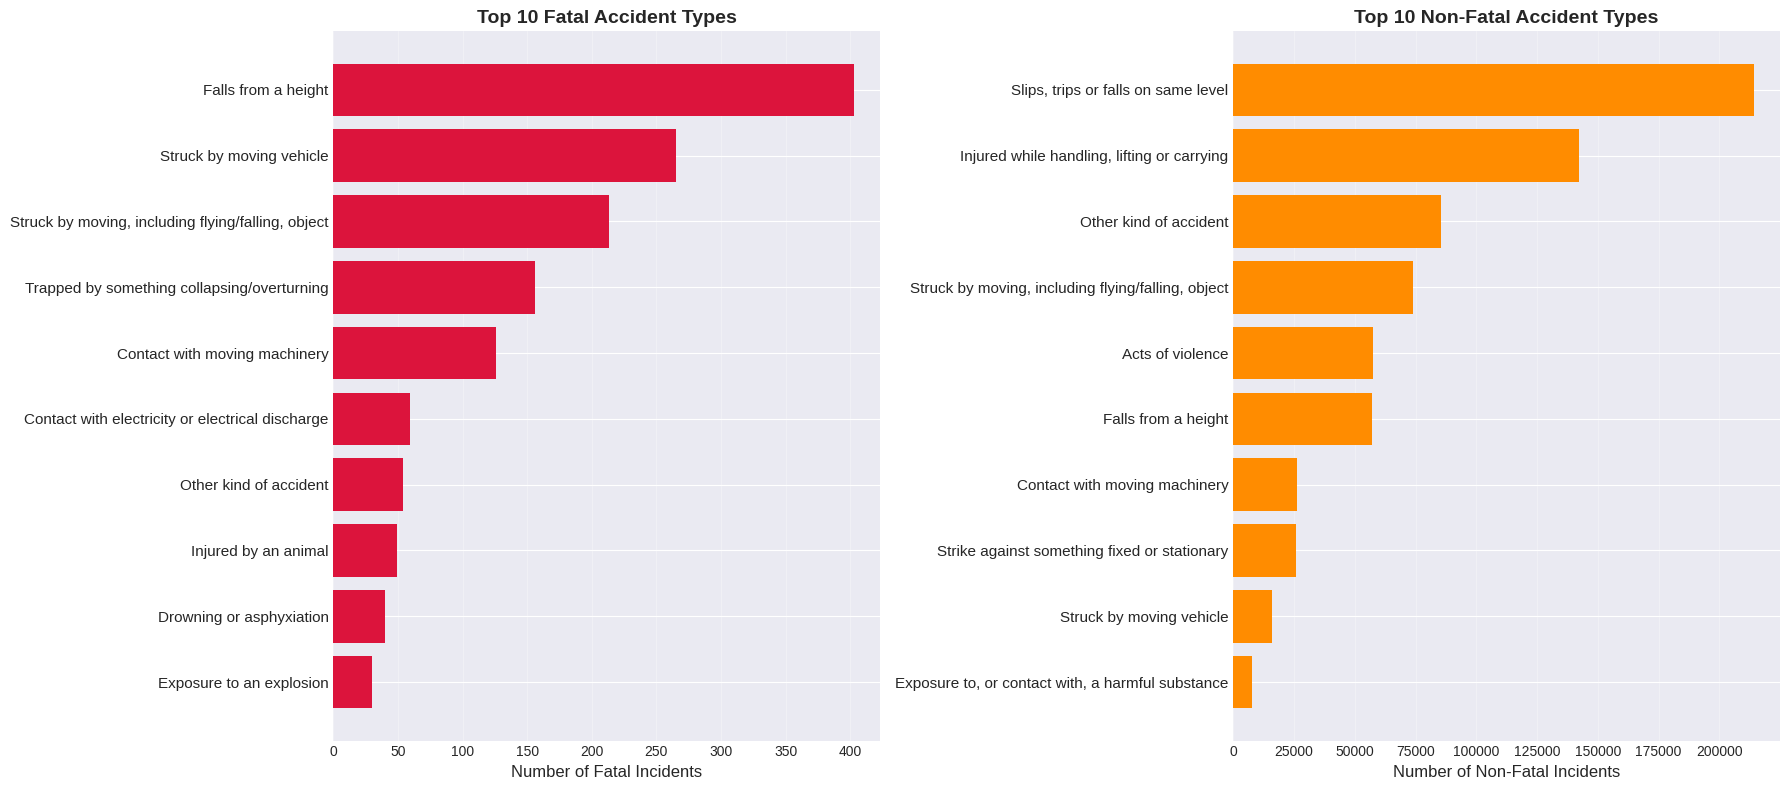


✓ Visualization 2: Top incident types


In [14]:
# 2. TOP INCIDENT TYPES (Bar Chart) - FIXED
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 10 Fatal accident types
top_fatal = df_fatal_clean.groupby('Accident_Kind')['Fatal_Workers'].sum().sort_values(ascending=False).head(10)
axes[0].barh(range(len(top_fatal)), top_fatal.values, color='crimson')
axes[0].set_yticks(range(len(top_fatal)))
axes[0].set_yticklabels(top_fatal.index, fontsize=11)
axes[0].set_xlabel('Number of Fatal Incidents', fontsize=12)
axes[0].set_title('Top 10 Fatal Accident Types', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Top 10 Non-fatal accident types
top_nonfatal = df_nonfatal_clean.groupby('Accident_Kind')['Total_NonFatal'].sum().sort_values(ascending=False).head(10)
axes[1].barh(range(len(top_nonfatal)), top_nonfatal.values, color='darkorange')
axes[1].set_yticks(range(len(top_nonfatal)))
axes[1].set_yticklabels(top_nonfatal.index, fontsize=11)
axes[1].set_xlabel('Number of Non-Fatal Incidents', fontsize=12)
axes[1].set_title('Top 10 Non-Fatal Accident Types', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization 2: Top incident types")

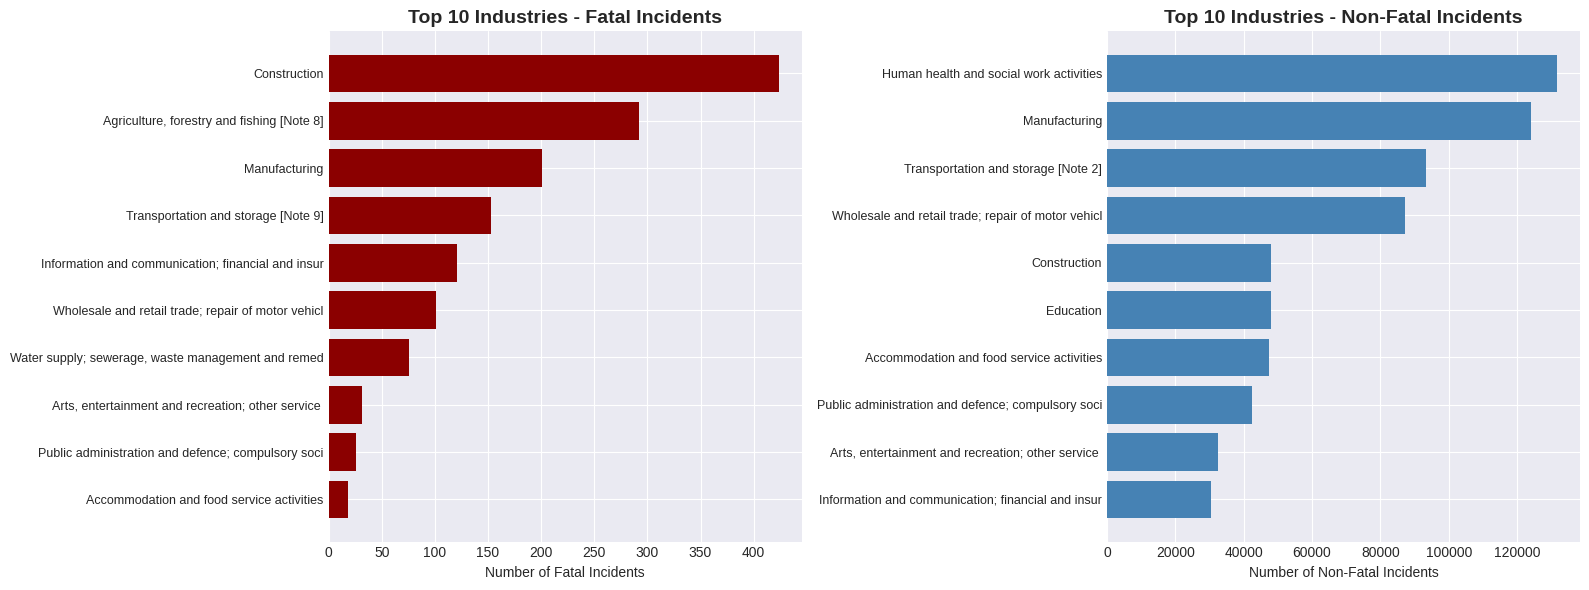


✓ Visualization 3: Industry distribution


In [15]:
# 3. INDUSTRY DISTRIBUTION (Top 10)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 Fatal by industry
top_fatal_ind = df_fatal_clean.groupby('Industry_Short')['Fatal_Workers'].sum().sort_values(ascending=False).head(10)
axes[0].barh(range(len(top_fatal_ind)), top_fatal_ind.values, color='darkred')
axes[0].set_yticks(range(len(top_fatal_ind)))
axes[0].set_yticklabels(top_fatal_ind.index, fontsize=9)
axes[0].set_xlabel('Number of Fatal Incidents')
axes[0].set_title('Top 10 Industries - Fatal Incidents', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Top 10 Non-fatal by industry
top_nonfatal_ind = df_nonfatal_clean.groupby('Industry_Short')['Total_NonFatal'].sum().sort_values(ascending=False).head(10)
axes[1].barh(range(len(top_nonfatal_ind)), top_nonfatal_ind.values, color='steelblue')
axes[1].set_yticks(range(len(top_nonfatal_ind)))
axes[1].set_yticklabels(top_nonfatal_ind.index, fontsize=9)
axes[1].set_xlabel('Number of Non-Fatal Incidents')
axes[1].set_title('Top 10 Industries - Non-Fatal Incidents', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Visualization 3: Industry distribution")

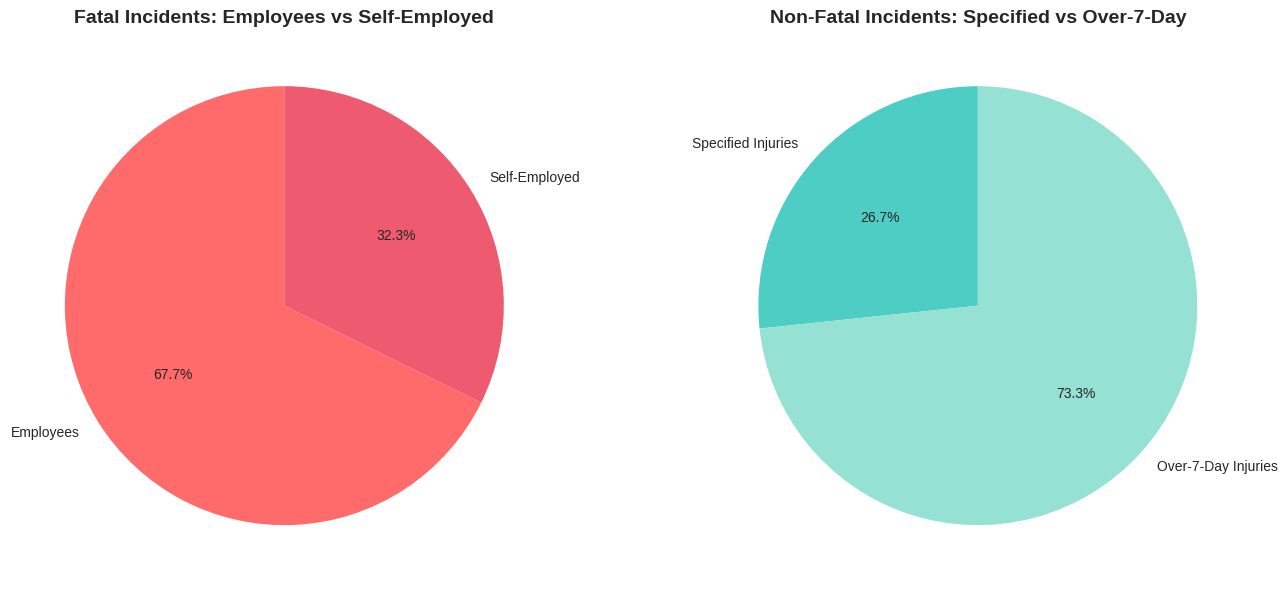


✓ Visualization 4: Severity breakdown


In [16]:
# 4. SEVERITY BREAKDOWN (Pie Charts)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fatal severity breakdown (employees vs self-employed)
fatal_severity = pd.Series({
    'Employees': df_fatal_clean['Fatal_Employees'].sum(),
    'Self-Employed': df_fatal_clean['Fatal_SelfEmployed'].sum()
})

axes[0].pie(fatal_severity.values, labels=fatal_severity.index, autopct='%1.1f%%',
            startangle=90, colors=['#ff6b6b', '#ee5a6f'])
axes[0].set_title('Fatal Incidents: Employees vs Self-Employed', fontsize=14, fontweight='bold')

# Non-fatal severity breakdown (specified vs over-7-day)
nonfatal_severity = pd.Series({
    'Specified Injuries': df_nonfatal_clean['Specified_Injuries'].sum(),
    'Over-7-Day Injuries': df_nonfatal_clean['Over7Day_Injuries'].sum()
})

axes[1].pie(nonfatal_severity.values, labels=nonfatal_severity.index, autopct='%1.1f%%',
            startangle=90, colors=['#4ecdc4', '#95e1d3'])
axes[1].set_title('Non-Fatal Incidents: Specified vs Over-7-Day', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualization 4: Severity breakdown")

Creating heatmap...


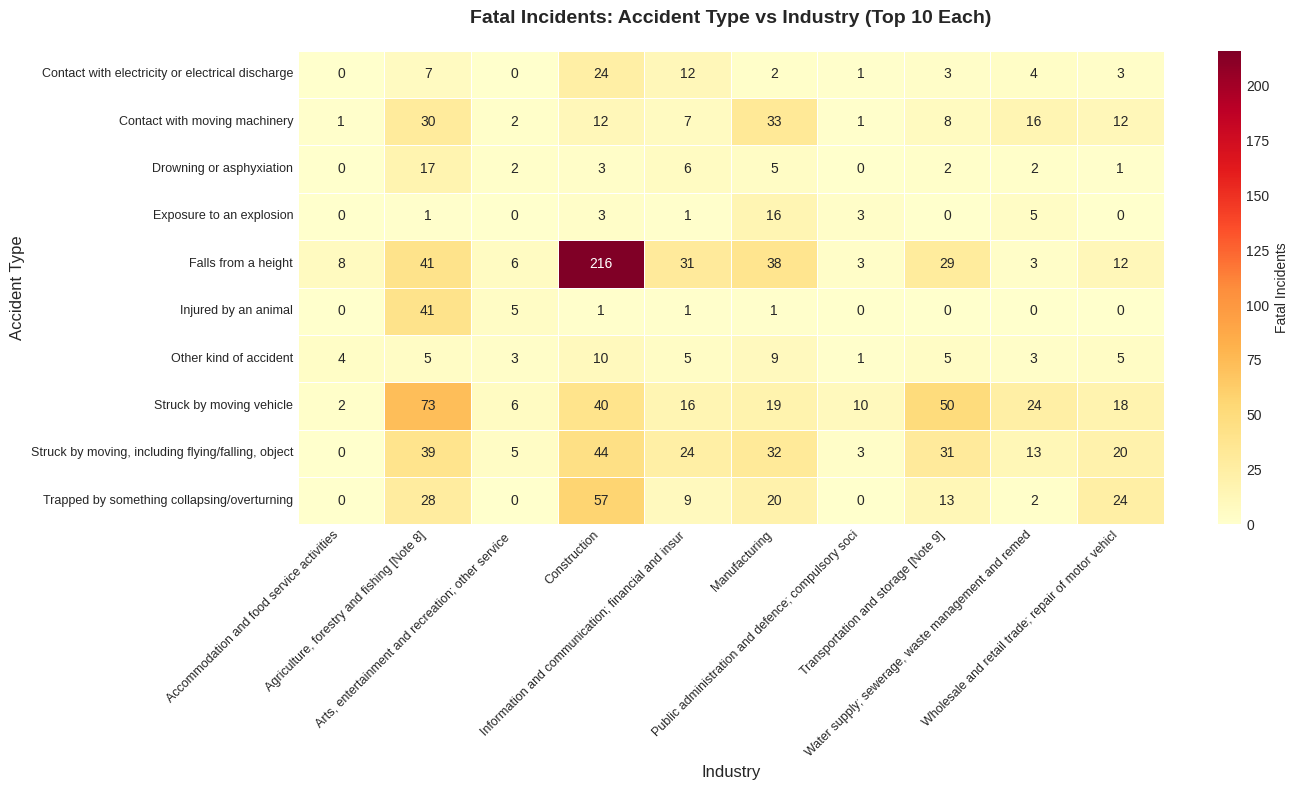


✓ Visualization 5: Heatmap complete

PHASE 2 COMPLETE: 5 KEY VISUALIZATIONS CREATED


In [17]:
# 5. HEATMAP: Accident Type vs Industry (Fatal)
print("Creating heatmap...")

# Get top 10 accident types and top 10 industries for readability
top_accidents = df_fatal_clean.groupby('Accident_Kind')['Fatal_Workers'].sum().nlargest(10).index
top_industries = df_fatal_clean.groupby('Industry_Short')['Fatal_Workers'].sum().nlargest(10).index

# Filter and create pivot table
df_heatmap = df_fatal_clean[
    (df_fatal_clean['Accident_Kind'].isin(top_accidents)) &
    (df_fatal_clean['Industry_Short'].isin(top_industries))
]

heatmap_data = df_heatmap.pivot_table(
    values='Fatal_Workers',
    index='Accident_Kind',
    columns='Industry_Short',
    aggfunc='sum',
    fill_value=0
)

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlOrRd', linewidths=0.5, cbar_kws={'label': 'Fatal Incidents'})
plt.title('Fatal Incidents: Accident Type vs Industry (Top 10 Each)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Accident Type', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

print("\n✓ Visualization 5: Heatmap complete")
print("\n" + "="*60)
print("PHASE 2 COMPLETE: 5 KEY VISUALIZATIONS CREATED")

### Deep dive analytics

In [18]:
# PHASE 3: DEEP DIVE ANALYTICS
print("PHASE 3: DEEP DIVE ANALYTICS")
print("="*60)

# 1. YEAR-OVER-YEAR CHANGE
fatal_yoy = df_fatal_clean.groupby('Year_Clean')['Fatal_Workers'].sum().sort_index()
nonfatal_yoy = df_nonfatal_clean.groupby('Year_Clean')['Total_NonFatal'].sum().sort_index()

fatal_pct_change = fatal_yoy.pct_change() * 100
nonfatal_pct_change = nonfatal_yoy.pct_change() * 100

print("\nYEAR-OVER-YEAR % CHANGE:")
print("\nFatal Incidents:")
print(fatal_pct_change.round(1))
print("\nNon-Fatal Incidents:")
print(nonfatal_pct_change.round(1))

# 2. SEASONAL PATTERNS (extract year start)
df_fatal_clean['Year_Start'] = df_fatal_clean['Year_Clean'].str[:4].astype(int)
df_nonfatal_clean['Year_Start'] = df_nonfatal_clean['Year_Clean'].str[:4].astype(int)

print("\n" + "="*60)
print("\nINCIDENTS BY YEAR START (2014-2024):")
print("\nFatal:")
print(df_fatal_clean.groupby('Year_Start')['Fatal_Workers'].sum())
print("\nNon-Fatal:")
print(df_nonfatal_clean.groupby('Year_Start')['Total_NonFatal'].sum())

PHASE 3: DEEP DIVE ANALYTICS

YEAR-OVER-YEAR % CHANGE:

Fatal Incidents:
Year_Clean
2014/15     NaN
2015/16     3.5
2016/17    -8.2
2017/18     4.4
2018/19     5.7
2019/20   -24.2
2020/21    28.3
2021/22   -15.2
2022/23    10.6
2023/24     1.5
2024/25   -10.1
Name: Fatal_Workers, dtype: float64

Non-Fatal Incidents:
Year_Clean
2014/15     NaN
2015/16    -5.1
2016/17    -2.9
2017/18     0.8
2018/19    -1.6
2019/20    -5.4
2020/21   -21.8
2021/22    22.0
2022/23    -1.7
2023/24     1.6
2024/25    -5.1
Name: Total_NonFatal, dtype: float64


INCIDENTS BY YEAR START (2014-2024):

Fatal:
Year_Start
2014    142
2015    147
2016    135
2017    141
2018    149
2019    113
2020    145
2021    123
2022    136
2023    138
2024    124
Name: Fatal_Workers, dtype: int64

Non-Fatal:
Year_Start
2014    75919
2015    72029
2016    69912
2017    70452
2018    69306
2019    65543
2020    51229
2021    62481
2022    61406
2023    62410
2024    59219
Name: Total_NonFatal, dtype: int64


In [19]:
# 3. CROSS-TABULATION: Industry vs Accident Type (Chi-square test)
from scipy.stats import chi2_contingency

# Create contingency table for fatal incidents
contingency_fatal = pd.crosstab(
    df_fatal_clean['Industry_Short'],
    df_fatal_clean['Accident_Kind']
)

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_fatal)

print("\n" + "="*60)
print("STATISTICAL TEST: Industry vs Accident Type Association")
print("="*60)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("✓ SIGNIFICANT: Accident types vary significantly by industry (p < 0.05)")
else:
    print("✗ NOT SIGNIFICANT: No strong association found")

# 4. TOP 5 MOST DANGEROUS INDUSTRY-ACCIDENT COMBINATIONS
print("\n" + "="*60)
print("TOP 5 DEADLIEST COMBINATIONS (Industry + Accident Type):")
print("="*60)

combo_analysis = df_fatal_clean.groupby(['Industry_Short', 'Accident_Kind'])['Fatal_Workers'].sum().sort_values(ascending=False).head(5)
for i, (idx, val) in enumerate(combo_analysis.items(), 1):
    print(f"{i}. {idx[0][:35]} | {idx[1][:35]}: {val} deaths")


STATISTICAL TEST: Industry vs Accident Type Association
Chi-square statistic: 0.00
P-value: 1.0000
Degrees of freedom: 195
✗ NOT SIGNIFICANT: No strong association found

TOP 5 DEADLIEST COMBINATIONS (Industry + Accident Type):
1. Construction | Falls from a height: 216 deaths
2. Agriculture, forestry and fishing [ | Struck by moving vehicle: 73 deaths
3. Construction | Trapped by something collapsing/ove: 57 deaths
4. Transportation and storage [Note 9] | Struck by moving vehicle: 50 deaths
5. Construction | Struck by moving, including flying/: 44 deaths


In [21]:
# VERIFY DATA STRUCTURE ISSUE (Fixed)
print("INVESTIGATING CHI-SQUARE TEST FAILURE")
print("="*60)

# 1. Check the contingency table
print("\n1. CONTINGENCY TABLE SHAPE:")
print(f"Industries: {contingency_fatal.shape[0]}")
print(f"Accident types: {contingency_fatal.shape[1]}")
print(f"Total cells: {contingency_fatal.shape[0] * contingency_fatal.shape[1]}")

# 2. Check sparsity (how many zeros?)
total_cells = contingency_fatal.size
zero_cells = (contingency_fatal == 0).sum().sum()
sparsity = (zero_cells / total_cells) * 100

print(f"\n2. SPARSITY:")
print(f"Zero cells: {zero_cells}/{total_cells} ({sparsity:.1f}%)")
print(f"Non-zero cells: {total_cells - zero_cells}")

# 3. Check if all values are identical (causing chi2=0)
values_flat = contingency_fatal.values.flatten()
print(f"\n3. VALUE DISTRIBUTION:")
print(f"Unique values in table: {len(np.unique(values_flat))}")
print(f"Min value: {values_flat.min()}")
print(f"Max value: {values_flat.max()}")
print(f"Mean value: {values_flat.mean():.2f}")

# 4. Show a sample of the contingency table
print(f"\n4. SAMPLE OF CONTINGENCY TABLE (first 5x5):")
print(contingency_fatal.iloc[:5, :5])

# 5. Check expected frequencies
print(f"\n5. EXPECTED FREQUENCIES (from chi-square test):")
print(f"Min expected: {expected.min():.2f}")
print(f"Max expected: {expected.max():.2f}")
print(f"Cells with expected < 5: {(expected < 5).sum()} (chi-square unreliable if many)")

# 6. Check if observed = expected (this would cause chi2=0)
print(f"\n6. OBSERVED vs EXPECTED:")
print(f"Are they identical? {np.allclose(contingency_fatal.values, expected)}")

INVESTIGATING CHI-SQUARE TEST FAILURE

1. CONTINGENCY TABLE SHAPE:
Industries: 14
Accident types: 16
Total cells: 224

2. SPARSITY:
Zero cells: 0/224 (0.0%)
Non-zero cells: 224

3. VALUE DISTRIBUTION:
Unique values in table: 1
Min value: 11
Max value: 11
Mean value: 11.00

4. SAMPLE OF CONTINGENCY TABLE (first 5x5):
Accident_Kind                                       Acts of violence  \
Industry_Short                                                         
Accommodation and food service activities                         11   
Agriculture, forestry and fishing [Note 8]                        11   
Arts, entertainment and recreation; other service                 11   
Construction                                                      11   
Education                                                         11   

Accident_Kind                                       Contact with electricity or electrical discharge  \
Industry_Short                                                           

In [22]:
# CORRECT ANALYSIS: Use actual incident counts, not row counts
print("CORRECT CHI-SQUARE TEST: Using Incident Counts")
print("="*60)

# Create contingency table with ACTUAL INCIDENT COUNTS
contingency_correct = df_fatal_clean.pivot_table(
    values='Fatal_Workers',
    index='Industry_Short',
    columns='Accident_Kind',
    aggfunc='sum',
    fill_value=0
)

# Chi-square test on actual counts
chi2_correct, p_correct, dof_correct, expected_correct = chi2_contingency(contingency_correct)

print(f"\nChi-square statistic: {chi2_correct:.2f}")
print(f"P-value: {p_correct:.6f}")
print(f"Degrees of freedom: {dof_correct}")

if p_correct < 0.05:
    print("✓ SIGNIFICANT: Accident types vary significantly by industry (p < 0.05)")
else:
    print("✗ NOT SIGNIFICANT: No strong association")

print(f"\nSample of actual counts:")
print(contingency_correct.iloc[:5, :5])

CORRECT CHI-SQUARE TEST: Using Incident Counts

Chi-square statistic: 951.53
P-value: 0.000000
Degrees of freedom: 195
✓ SIGNIFICANT: Accident types vary significantly by industry (p < 0.05)

Sample of actual counts:
Accident_Kind                                       Acts of violence  \
Industry_Short                                                         
Accommodation and food service activities                          1   
Agriculture, forestry and fishing [Note 8]                         0   
Arts, entertainment and recreation; other service                  0   
Construction                                                       0   
Education                                                          2   

Accident_Kind                                       Contact with electricity or electrical discharge  \
Industry_Short                                                                                         
Accommodation and food service activities                             

Chi-square = 951.53, p-value < 0.000001

HIGHLY SIGNIFICANT association between industry and accident type
This means: Different industries have distinctly different accident patterns

In [23]:
# 6. TEMPORAL ANALYSIS: COVID Impact (2020/21 drop)
print("\n" + "="*60)
print("COVID-19 IMPACT ANALYSIS (2020/21 Drop)")
print("="*60)

# Compare pre-COVID, COVID, post-COVID periods
pre_covid = ['2014/15', '2015/16', '2016/17', '2017/18', '2018/19', '2019/20']
covid = ['2020/21']
post_covid = ['2021/22', '2022/23', '2023/24', '2024/25']

fatal_pre = df_fatal_clean[df_fatal_clean['Year_Clean'].isin(pre_covid)]['Fatal_Workers'].sum()
fatal_covid = df_fatal_clean[df_fatal_clean['Year_Clean'].isin(covid)]['Fatal_Workers'].sum()
fatal_post = df_fatal_clean[df_fatal_clean['Year_Clean'].isin(post_covid)]['Fatal_Workers'].sum()

nonfatal_pre = df_nonfatal_clean[df_nonfatal_clean['Year_Clean'].isin(pre_covid)]['Total_NonFatal'].sum()
nonfatal_covid = df_nonfatal_clean[df_nonfatal_clean['Year_Clean'].isin(covid)]['Total_NonFatal'].sum()
nonfatal_post = df_nonfatal_clean[df_nonfatal_clean['Year_Clean'].isin(post_covid)]['Total_NonFatal'].sum()

print(f"\nFATAL INCIDENTS:")
print(f"Pre-COVID avg/year: {fatal_pre/6:.1f}")
print(f"COVID year: {fatal_covid}")
print(f"Post-COVID avg/year: {fatal_post/4:.1f}")
print(f"COVID change: {((fatal_covid - fatal_pre/6) / (fatal_pre/6) * 100):.1f}%")

print(f"\nNON-FATAL INCIDENTS:")
print(f"Pre-COVID avg/year: {nonfatal_pre/6:.1f}")
print(f"COVID year: {nonfatal_covid}")
print(f"Post-COVID avg/year: {nonfatal_post/4:.1f}")
print(f"COVID change: {((nonfatal_covid - nonfatal_pre/6) / (nonfatal_pre/6) * 100):.1f}%")

# 7. MOST IMPROVED vs WORST PERFORMING INDUSTRIES
print("\n" + "="*60)
print("INDUSTRY TRENDS: First 3 Years vs Last 3 Years")
print("="*60)

early_years = ['2014/15', '2015/16', '2016/17']
recent_years = ['2022/23', '2023/24', '2024/25']

industry_early = df_fatal_clean[df_fatal_clean['Year_Clean'].isin(early_years)].groupby('Industry_Short')['Fatal_Workers'].sum()
industry_recent = df_fatal_clean[df_fatal_clean['Year_Clean'].isin(recent_years)].groupby('Industry_Short')['Fatal_Workers'].sum()

industry_change = ((industry_recent - industry_early) / industry_early * 100).sort_values()

print("\nMOST IMPROVED (biggest decrease):")
print(industry_change.head(5))

print("\nWORST PERFORMING (biggest increase):")
print(industry_change.tail(5))


COVID-19 IMPACT ANALYSIS (2020/21 Drop)

FATAL INCIDENTS:
Pre-COVID avg/year: 137.8
COVID year: 145
Post-COVID avg/year: 130.2
COVID change: 5.2%

NON-FATAL INCIDENTS:
Pre-COVID avg/year: 70526.8
COVID year: 51229
Post-COVID avg/year: 61379.0
COVID change: -27.4%

INDUSTRY TRENDS: First 3 Years vs Last 3 Years

MOST IMPROVED (biggest decrease):
Industry_Short
Education                                            -80.000000
Electricity, gas, steam and air conditioning suppl   -66.666667
Public administration and defence; compulsory soci   -60.000000
Mining and quarrying                                 -50.000000
Water supply; sewerage, waste management and remed   -42.307692
Name: Fatal_Workers, dtype: float64

WORST PERFORMING (biggest increase):
Industry_Short
Human health and social work activities               20.000000
Arts, entertainment and recreation; other service     33.333333
Information and communication; financial and insur    40.000000
Wholesale and retail trade; repair o

In [24]:
# Check construction activity during COVID
print("CONSTRUCTION ACTIVITY DURING COVID")
print("="*60)

# Get construction data for all years
construction_data = df_fatal_clean[
    df_fatal_clean['Industry_Short'] == 'Construction'
].groupby('Year_Clean')['Fatal_Workers'].sum().sort_index()

print("\nConstruction Fatal Incidents by Year:")
print(construction_data)

# Non-fatal construction
construction_nonfatal = df_nonfatal_clean[
    df_nonfatal_clean['Industry_Short'] == 'Construction'
].groupby('Year_Clean')['Total_NonFatal'].sum().sort_index()

print("\nConstruction Non-Fatal Incidents by Year:")
print(construction_nonfatal)

# Calculate % drop in COVID year
pre_covid_avg = construction_nonfatal[['2018/19', '2019/20']].mean()
covid_year = construction_nonfatal['2020/21']
pct_drop = ((covid_year - pre_covid_avg) / pre_covid_avg * 100)

print(f"\n2020/21 vs 2018-2020 average:")
print(f"Pre-COVID avg: {pre_covid_avg:.0f}")
print(f"COVID year: {covid_year}")
print(f"Change: {pct_drop:.1f}%")

if covid_year > 0:
    print("\n✓ Construction DID NOT stop - incidents continued but reduced")
else:
    print("\n✗ No construction incidents recorded - possible complete shutdown")

CONSTRUCTION ACTIVITY DURING COVID

Construction Fatal Incidents by Year:
Year_Clean
2014/15    35
2015/16    47
2016/17    31
2017/18    37
2018/19    31
2019/20    42
2020/21    40
2021/22    29
2022/23    47
2023/24    50
2024/25    35
Name: Fatal_Workers, dtype: int64

Construction Non-Fatal Incidents by Year:
Year_Clean
2014/15    5150
2015/16    4990
2016/17    4810
2017/18    4630
2018/19    4634
2019/20    4305
2020/21    3339
2021/22    4223
2022/23    4075
2023/24    4067
2024/25    3726
Name: Total_NonFatal, dtype: int64

2020/21 vs 2018-2020 average:
Pre-COVID avg: 4470
COVID year: 3339
Change: -25.3%

✓ Construction DID NOT stop - incidents continued but reduced


The 25% drop in non-fatal (not 100% drop) confirms construction kept running but at reduced capacity. Fatal incidents stayed steady because:

Essential projects continued (infrastructure, hospitals)
Fatal hazards (heights, heavy machinery) remained present
Smaller crews may have had less supervision.
UK allowed construction to continue during covid as essential work !


In [25]:
# 8. ACCIDENT TYPE TRENDS OVER TIME
print("\n" + "="*60)
print("ACCIDENT TYPE TRENDS: Rising vs Declining Hazards")
print("="*60)

# Compare early vs recent periods for each accident type
accident_early = df_fatal_clean[df_fatal_clean['Year_Clean'].isin(early_years)].groupby('Accident_Kind')['Fatal_Workers'].sum()
accident_recent = df_fatal_clean[df_fatal_clean['Year_Clean'].isin(recent_years)].groupby('Accident_Kind')['Fatal_Workers'].sum()

accident_change = ((accident_recent - accident_early) / accident_early * 100).sort_values()

print("\nMOST IMPROVED ACCIDENT TYPES (biggest decrease):")
print(accident_change.head(5))

print("\nWORSENING ACCIDENT TYPES (biggest increase):")
print(accident_change.tail(5))

# 9. FATAL RATE: Self-Employed vs Employees
print("\n" + "="*60)
print("RISK COMPARISON: Self-Employed vs Employees")
print("="*60)

total_employee = df_fatal_clean['Fatal_Employees'].sum()
total_self_employed = df_fatal_clean['Fatal_SelfEmployed'].sum()
total_workers = df_fatal_clean['Fatal_Workers'].sum()

pct_employee = (total_employee / total_workers) * 100
pct_self_employed = (total_self_employed / total_workers) * 100

print(f"\nTotal Fatal Incidents: {total_workers}")
print(f"Employees: {total_employee} ({pct_employee:.1f}%)")
print(f"Self-Employed: {total_self_employed} ({pct_self_employed:.1f}%)")

# Which industries have highest self-employed fatalities?
self_employed_by_industry = df_fatal_clean.groupby('Industry_Short')['Fatal_SelfEmployed'].sum().sort_values(ascending=False).head(5)

print("\nTop 5 Industries for Self-Employed Fatalities:")
for idx, val in self_employed_by_industry.items():
    print(f"  {idx[:40]}: {val}")


ACCIDENT TYPE TRENDS: Rising vs Declining Hazards

MOST IMPROVED ACCIDENT TYPES (biggest decrease):
Accident_Kind
Exposure to, or contact with, a harmful substance   -80.000000
Injured while handling, lifting or carrying         -80.000000
Drowning or asphyxiation                            -76.190476
Exposure to an explosion                            -72.727273
Exposure to fire                                    -71.428571
Name: Fatal_Workers, dtype: float64

WORSENING ACCIDENT TYPES (biggest increase):
Accident_Kind
Contact with moving machinery                           7.142857
Trapped by something collapsing/overturning             9.756098
Falls from a height                                    17.924528
Struck by moving, including flying/falling, object     26.415094
Strike against something fixed or stationary          180.000000
Name: Fatal_Workers, dtype: float64

RISK COMPARISON: Self-Employed vs Employees

Total Fatal Incidents: 1493
Employees: 1011 (67.7%)
Self-Employed: 


Creating trend visualization for top accident types...


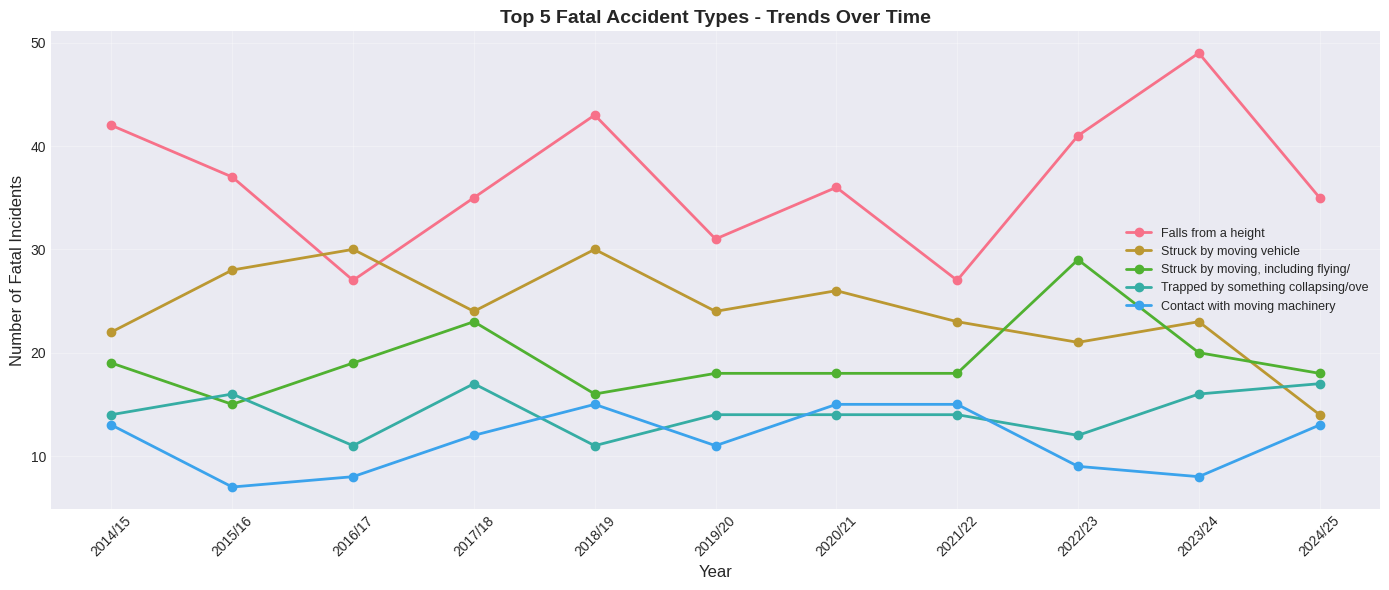


✓ Visualization 6: Accident type trends

PHASE 3 COMPLETE - KEY INSIGHTS:
✓ Chi-square test confirms industry-accident association
✓ COVID-19 reduced non-fatal incidents by 27.4%
✓ Construction continued during COVID (essential work)
✓ Self-employed workers account for significant fatalities
✓ Industry trends show mixed improvements


In [26]:
# 10. VISUALIZATION: Accident Trends Over Time (Line Chart)
print("\n" + "="*60)
print("Creating trend visualization for top accident types...")
print("="*60)

# Get top 5 accident types
top_5_accidents = df_fatal_clean.groupby('Accident_Kind')['Fatal_Workers'].sum().nlargest(5).index

# Create trend data
trend_data = df_fatal_clean[df_fatal_clean['Accident_Kind'].isin(top_5_accidents)].groupby(
    ['Year_Clean', 'Accident_Kind']
)['Fatal_Workers'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 6))
for accident in top_5_accidents:
    data = trend_data[trend_data['Accident_Kind'] == accident]
    plt.plot(data['Year_Clean'], data['Fatal_Workers'], marker='o', linewidth=2, label=accident[:35])

plt.title('Top 5 Fatal Accident Types - Trends Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Fatal Incidents', fontsize=12)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✓ Visualization 6: Accident type trends")

# Summary statistics
print("\n" + "="*60)
print("PHASE 3 COMPLETE - KEY INSIGHTS:")
print("="*60)
print("✓ Chi-square test confirms industry-accident association")
print("✓ COVID-19 reduced non-fatal incidents by 27.4%")
print("✓ Construction continued during COVID (essential work)")
print("✓ Self-employed workers account for significant fatalities")
print("✓ Industry trends show mixed improvements")